## This notebook is used for the analysis of simulations carried out with SOMA

#### It should only be used for binary homopolymer blends. It is used to calculate the boundary densities and currents in the case where polymer types A and B are  being converted into each other at the x boundaries at a specific rate. There is also an analytical approach to this, which depends on the single chain diffusion coefficient, which in turn needs to be extracted from the simulation. All the calculations are done for type A.


In [425]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [426]:
class SOMA_run:
    def __init__(self,dir_name,area51_len):
        ##name of directory with simulation data
        self.dir_name=dir_name
        ##length of area51 in x direction. Need to exclude this for density profile calculations
        self.area51_len = area51_len
        with h5py.File(f'{self.dir_name}/coord.h5', 'r') as f:
            ##number of beads per polymer
            self.N=int(f['parameter/reference_Nbeads'][()]) 
            ##number of polymers
            self.n_polym=int(f['parameter/n_polymers'][()]) 
            self.n_poly_type=int(f['parameter/n_poly_type'][()]) 
            ##box dimensions 
            self.lxyz=np.array(f['parameter/lxyz'])
            ##box discretization
            self.nxyz=np.array(f['parameter/nxyz'])
            ##true lx (without area51)
            self.lx_true=(self.nxyz[0]-2*self.area51_len)/self.nxyz[0]*self.lxyz[0]
            ##conversion rate for each reaction
            self.rates=np.array(f['polyconversion/rate'])
            ##number of area 51 cells
            self.area51=sum(np.array(f['area51']).flatten())

            
        ##load analysis data
        with h5py.File(f'{self.dir_name}/coord_ana.h5', 'r') as f:
            ##density field averaged over time, y and z
            self.phi=np.array(f['density_field']).mean(axis=(0,3,4))[:,self.area51_len:self.nxyz[0]-self.area51_len]
            ##sum of density fields
            self.phitot=sum(self.phi)
            ##normalized densities
            self.phi_norm=self.phi/self.phitot
            #self.phi_norm=self.phi
            ##numbers of polymers converted per reaction
            self.num_conversions=np.array(f['num_conversions']) 
            self.delta_mc_num_conversions=np.array(f['num_conversions'].attrs["DeltaMC"])
            ##MSD
            self.MSD=np.array(f['MSD'])
            
            
        
        ##cell volume
        self.V_cell=np.prod(self.lxyz)/np.prod(self.nxyz)
        ##total simulation time
        self.t=self.delta_mc_num_conversions*len(self.num_conversions)
        ##accessible volume
        self.V=np.prod(self.lxyz)-self.V_cell*self.area51
        ##field scaling factor
        self.scale=(np.prod(self.nxyz)-self.area51)/(self.N*self.n_polym)
        ##Nbar
        self.Nbar=self.n_polym/self.V
        ##average bead density
        self.rho0=self.n_polym*self.N/self.V
        ##self diffusion coefficients
        self.D_A=self.MSD[:,3][-1]/(6*self.t)
        self.D_B=self.MSD[:,11][-1]/(6*self.t)
        ##onsager coefficients (without density factor)
        self.lam_A=self.D_A*self.N
        self.lam_B=self.D_B*self.N
        
            
    def poly_current_num(self,reaction=2):
        """Polymer current over whole simulation time. Assumes that current is only in x direction and that it is proportional to the number of polymer conversions.

        """
        A=self.lxyz[1]*self.lxyz[2] ##area of yz plane
        ##get polymer current per deltamc
        j=np.array([self.num_conversions[i+1,2]-self.num_conversions[i,2] for i in range(1,len(self.num_conversions)-1)])/(A*self.delta_mc_num_conversions)
        J_mean=np.mean(j)
        return J_mean

    
    def poly_current_ana(self,r):
        """Analytical equation for polymer current assuming linear density profile.
        """
        r=self.N*r
        return self.lam_A*r/(2+self.N*r*self.lx_true/(self.rho0*self.lam_A))
        
        
    
    def mean_dens(self,idx,poly_type=0):
        """Density averaged over time, y and z coordinate at given position x.

        """
        return self.phi_norm[poly_type,idx]
    
    def plot_density_profile(self,poly_type=0):
        """Plot x coordinate density profile.
        """
        xmin=0
        xmax=self.lx_true
        x_grid=np.linspace(xmin,xmax,self.nxyz[0]-2*self.area51_len)
        fig=plt.figure(dpi=100)
        plt.title("Density profile")
        plt.xlabel("$x$")
        plt.ylabel("$\phi$")
        plt.plot(x_grid,self.phi_norm[poly_type])
        plt.show()
        return
            
    def phi0_ana(self):
        """Analytical equation for left boundary density assuming linear density profile.
        """
        r=self.N*self.rates[0]
        return 1/(2+self.N*r*self.lx_true/(self.lam_A*self.rho0))

        
        
    

In [427]:
area51_len = 3

In [428]:
a=SOMA_run(0,area51_len)

In [429]:
runs=[]
for i in range(10):
    runs.append(SOMA_run(i,area51_len))

In [430]:
rates=np.array([])
J_num=np.array([])
J_ana=np.array([])
phi0_ana=np.array([])
phi0_num=np.array([])
for i in range(10):
    test=runs[i]
    rate=test.rates[0]
    J_num=np.append(J_num,test.poly_current_num(2))
    J_ana=np.append(J_ana,test.poly_current_ana(rate))
    phi0_ana=np.append(phi0_ana,test.phi0_ana())
    phi0_num=np.append(phi0_num,test.mean_dens(0))
    rates=np.append(rates,rate)
print(phi0_ana)

[0.39812322 0.33093292 0.24759144 0.19739965 0.16443163 0.14077669
 0.12332542 0.10923847 0.09863936 0.0896624 ]


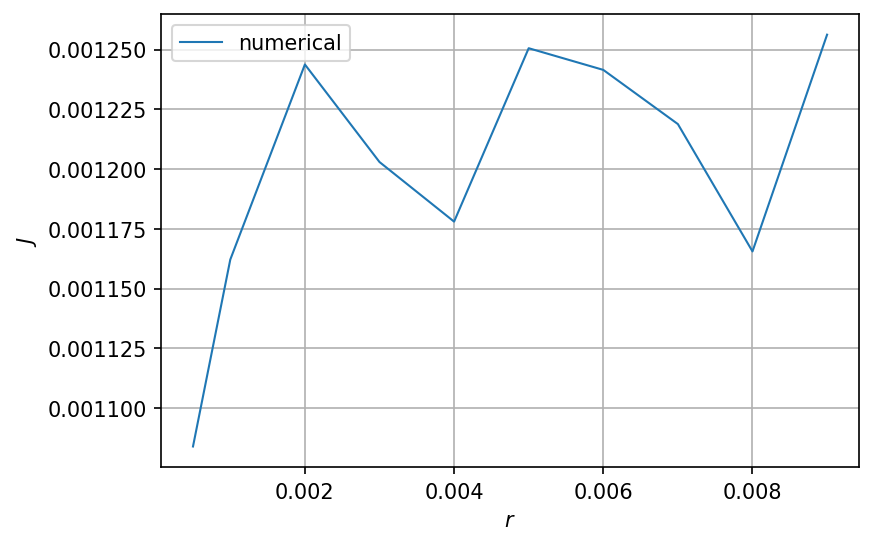

In [433]:
plt.figure(dpi=150)
plt.grid()
plt.xlabel("$r$")
plt.ylabel("$J$")
plt.plot(rates,J_num,label="numerical",lw=1)
#plt.plot(rates,J_ana,label="analytical",lw=1)
plt.legend()

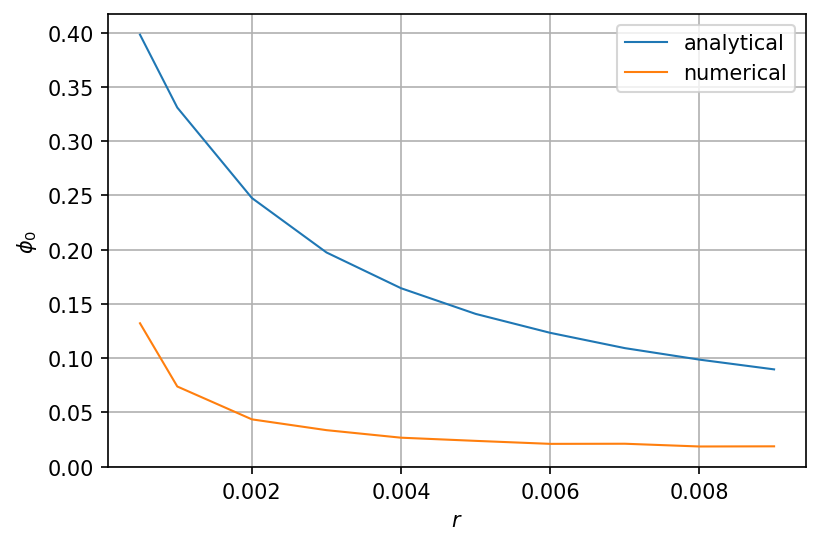

In [432]:
plt.figure(dpi=150)
plt.grid()
plt.xlabel("$r$")
plt.ylabel("$\phi_0$")
plt.plot(rates,phi0_ana,label="analytical",lw=1)
plt.plot(rates,phi0_num,label="numerical",lw=1)
plt.legend()